# Tarea 2: Experimentos con Redes Neuronales Convolucionales (CNNs)

**Nombre:** Diego Sapunar Opazo

**Num. Alumno:** 14637480

## Objetivo

En esta actividad tendrán la oportunidad de continuar experimentando con CNNs. En particular, pondrán en práctica lo que conversamos sobre refinamiento de modelos (finetunning), funciones de pérdida y funciones de activación. Adicionalmente, a diferencia de la tarea 1 en que utilizaron Keras, en esta oportunidad utilizarán (PyTorch).

## 0. Import Packages

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
import time
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
from matplotlib import pyplot as plt

## 1. Finetunning y funciones de activación (50%)

En esta parte de la tarea se utilizarán el set de datos Birds...

### Actividad 1

Entrenar un modelo de RestNet50 con PyTorch utilizando el set de datos Birds inicializando los pesos en fomra aleatoria. En base al set de entrenamiento, validación y test, analizar sus resultados incluyendo gráficos que indiquen:
* Evolución de función de pérdida vd número de épocas.
* Evolución de exactitud de clasificación vs número de épocas.
* Exactitud de clasificación en set de test.

#### Source: material del SidIng - Ayudantias

In [14]:
def train_model(model, criterion, optimizer, scheduler, dic, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            dic[epoch].append((epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [86]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/BirdsDataset/CUB_200_2011'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [16]:
dic_values = {}

for i in range(50):
    dic_values[i] = []


In [19]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dic_values,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 5.5998 Acc: 0.0058
val Loss: 7.6072 Acc: 0.0104

Epoch 1/49
----------
train Loss: 5.2767 Acc: 0.0089
val Loss: 7.3391 Acc: 0.0156

Epoch 2/49
----------
train Loss: 5.1770 Acc: 0.0114
val Loss: 10.5515 Acc: 0.0121

Epoch 3/49
----------
train Loss: 5.1045 Acc: 0.0112
val Loss: 10.3223 Acc: 0.0234

Epoch 4/49
----------
train Loss: 5.0410 Acc: 0.0163
val Loss: 8.4376 Acc: 0.0199

Epoch 5/49
----------
train Loss: 4.9959 Acc: 0.0172
val Loss: 16.6021 Acc: 0.0182

Epoch 6/49
----------
train Loss: 4.9557 Acc: 0.0202
val Loss: 12.0085 Acc: 0.0147

Epoch 7/49
----------
train Loss: 4.9073 Acc: 0.0211
val Loss: 9.3081 Acc: 0.0260

Epoch 8/49
----------
train Loss: 4.8741 Acc: 0.0270
val Loss: 11.3173 Acc: 0.0381

Epoch 9/49
----------
train Loss: 4.7721 Acc: 0.0312
val Loss: 45.5115 Acc: 0.0355

Epoch 10/49
----------
train Loss: 4.7286 Acc: 0.0384
val Loss: 92.9519 Acc: 0.0381

Epoch 11/49
----------
train Loss: 4.6836 Acc: 0.0400
val Loss: 34.1468 Acc: 0.

In [ ]:
# Eliminando Key de mas
del dic_values[50]

In [64]:
train_losses = []
val_losses = []

train_acc = []
val_acc = []

for epoch in dic_values:
    train_losses.append(dic_values[epoch][0][0])
    val_losses.append(dic_values[epoch][1][0])
    
    train_acc.append(dic_values[epoch][0][1].item())
    val_acc.append(dic_values[epoch][1][1].item())

#### Evolución de función de pérdida vs número de épocas

Text(0.5, 0, 'Épocas(Epochs)')

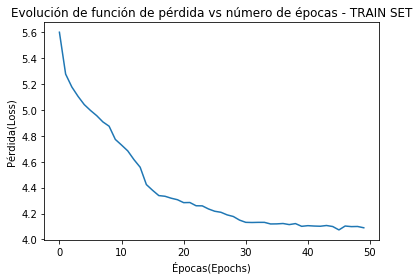

In [65]:
# line
plt.plot(train_losses)

# title
plt.title("Evolución de función de pérdida vs número de épocas - TRAIN SET")

# labels de los ejes
plt.ylabel('Pérdida(Loss)')
plt.xlabel('Épocas(Epochs)')

Text(0.5, 0, 'Épocas(Epochs)')

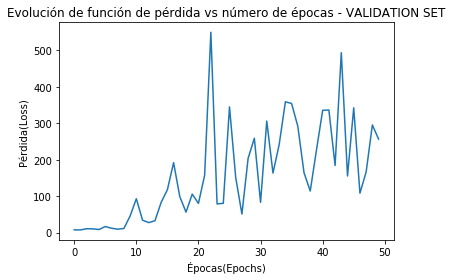

In [66]:
# line
plt.plot(val_losses)

# title
plt.title("Evolución de función de pérdida vs número de épocas - VALIDATION SET")

# labels de los ejes
plt.ylabel('Pérdida(Loss)')
plt.xlabel('Épocas(Epochs)')

#### Evolución de exactitud de clasificación vs número de épocas

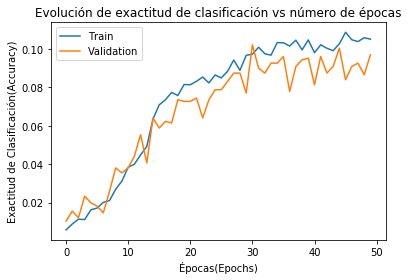

In [160]:
# line
plt.plot(train_acc)
plt.plot(val_acc)

# title
plt.title("Evolución de exactitud de clasificación vs número de épocas")

# labels de los ejes
plt.ylabel('Exactitud de Clasificación(Accuracy)')
plt.xlabel('Épocas(Epochs)')

# leyenda
plt.legend(['Train', 'Validation'])

#### Exactitud de clasificación final en set de test - también obtenemos los mejores y peores resultados por clase (para la Actividad 3)

Source: Ayudantia SidIng

In [99]:
'''
Vamos a testear nuestro modelo entrenado en nuesto set de test, guardando los correctos por clase.
'''

corrects = {}
examples_per_class = {}


for i in range(200):
    corrects[i] = 0
    examples_per_class[i] = 0
    

# Iterate over data.
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model_ft(inputs)
    
    _, preds = torch.max(outputs, 1)

    for j in range(4):
        if (labels.data[j].item() == preds[j].item()):
            corrects[preds[j].item()] += 1
            
        examples_per_class[labels[j].item()] += 1
    

In [103]:
# Vamos a Obtener la Exactitud total
print((sum(corrects.values()))
      /(sum(examples_per_class.values())))

0.1


Vemos una Exactitud de clasificación Final (Accuracy) en el set de test de 0.1 = 10%

#### Analysis Actividad 1

Respecto a la Perdida vemos que la perdida menor en el set de train fue de **4.073229166770024** y en el set de val fue de **7.33907534776828**, sin duda esto es un reflejo que nuestro modelo se esta **sobre-entrenando**. También acerca de las pérdidas que va teniendo el modelo a lo largo del tiempo que el set de train baja de manera homogenea, y el modelo el train de set totalmente heterogenea, teniendo unos peaks muy extraños. Esto se debe a que la actualización de los pesos no esta siendo efectiva, ya se por el **sobre-entrenando** que esta generando el modelo, o también porque el batch_size que utilice es muy pequeño.

Respecto a la exactitud del modelo, vemos que la mayor exactitud en el set de train fue de **0.1087300749498575** y en el set de val fue de **0.10216450216450217**, siendo la del train de set mayor en **0.006565572785**, lo cual corresponde a un 6.5% mayor (estadisticamente = 0.1087300749498575/0.10216450216450217 - 1), lo cual si se considera representativo. Que la exactitud sea mayor en el set de train es un relfejo que existe un **sobre-entrenando**. También observando los gráficos se  en un comienzo suben homogenamente, pero desde un punto se separan (muy sutilmente, siendo que el Train continua subiendo y el Validate converge. Estas "separaciones" se deben a un **sobre-entrenando**. Esta separación ocurre en la epocs 13.

Respecto a la Exactitud de clasificación final en el set de test fue de 0.1, más cercana a la exactitud del set de validación que el de test, esto quiere decir que nuestra estrategia de validación es correcta. Problemas de este sobre-entrenamiento que ha sido mencionado a lo largo del analysis se puede deber que no tenemos muchos datos, lo cual es uno de los puntos fundamentales para obtener buenos resultados en redes de aprendizaje de máquinas profundas, o puede haber existido una mala definición de lo Hyperparametros, sin embargo, mi intuición e investogación tanto lo que hemos visto en clases como lo que he investigado por mi cuenta se debe a la primer argumento.

In [105]:
# Vamos a obtener las Accuracies de cada clase para la Actividad 3
acc_per_class = {}

for class_ in range(200):
    acc_per_class[class_] = ((corrects[class_]) / examples_per_class[class_])

#### Exportando los diccionarios

In [127]:
import json


json = json.dumps(corrects)
f = open("./corrects_act1.json","w")
f.write(json)
f.close()

json = json.dumps(examples_per_class)
f = open("./examples_per_class_act1.json","w")
f.write(json)
f.close()

json = json.dumps(acc_per_class)
f = open("./acc_per_class_act1.json","w")
f.write(json)
f.close()

### Actividad 2

Repita la actividad anterior, pero en lugar de inicializar los pesos en forma aleatoria, pre-entrene la red utilizando ImageNet y utilice los pesos resultantes como pesos resultantes como punto de inicio para entrenar ResNet 50 con el set de datos de Birds.

Analizar sus resultados incluyendo gráficos que indiquen:
* Evolución de función de pérdida vs número de épocas.
* Evolución de exactitud de clasificación vs número de épocas.
* Exactitud de clasificación final en set de test.

#### Entrenando Modelo

In [128]:
'''
Para poder relizar una correcta comparacion con la Actividad 1, se mantiene la misma implementación general.
'''

dic_values_act2 = {}

for i in range(50):
    dic_values_act2[i] = []


In [129]:
model_ft_act2 = models.resnet50(pretrained=True)
num_ftrs_act2 = model_ft_act2.fc.in_features
model_ft_act2.fc = nn.Linear(num_ftrs_act2, 200)

model_ft_act2 = model_ft_act2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_act2 = optim.SGD(model_ft_act2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_act2, step_size=15, gamma=0.1)

model_ft_act2 = train_model(model_ft_act2, criterion, optimizer_ft_act2, exp_lr_scheduler, dic_values_act2,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 4.1851 Acc: 0.1083
val Loss: 2.3808 Acc: 0.3506

Epoch 1/49
----------
train Loss: 2.9318 Acc: 0.2896
val Loss: 1.8325 Acc: 0.5316

Epoch 2/49
----------
train Loss: 2.4820 Acc: 0.3800
val Loss: 1.5659 Acc: 0.6009

Epoch 3/49
----------
train Loss: 2.2290 Acc: 0.4399
val Loss: 1.5702 Acc: 0.6199

Epoch 4/49
----------
train Loss: 2.0598 Acc: 0.4798
val Loss: 1.2834 Acc: 0.6823

Epoch 5/49
----------
train Loss: 1.9484 Acc: 0.5084
val Loss: 1.1854 Acc: 0.6926

Epoch 6/49
----------
train Loss: 1.8313 Acc: 0.5316
val Loss: 1.3677 Acc: 0.6667

Epoch 7/49
----------
train Loss: 1.7647 Acc: 0.5464
val Loss: 1.2110 Acc: 0.7126

Epoch 8/49
----------
train Loss: 1.7017 Acc: 0.5726
val Loss: 1.2877 Acc: 0.7152

Epoch 9/49
----------
train Loss: 1.6111 Acc: 0.5919
val Loss: 1.2236 Acc: 0.7004

Epoch 10/49
----------
train Loss: 1.5566 Acc: 0.5921
val Loss: 1.1842 Acc: 0.7152

Epoch 11/49
----------
train Loss: 1.5172 Acc: 0.6132
val Loss: 1.1890 Acc: 0.7394

Ep

In [130]:
train_losses_act2 = []
val_losses_act2 = []

train_acc_act2 = []
val_acc_act2 = []

for epoch in dic_values_act2:
    train_losses_act2.append(dic_values_act2[epoch][0][0])
    val_losses_act2.append(dic_values_act2[epoch][1][0])
    
    train_acc_act2.append(dic_values_act2[epoch][0][1].item())
    val_acc_act2.append(dic_values_act2[epoch][1][1].item())

#### Evolución de función de pérdida vs número de épocas

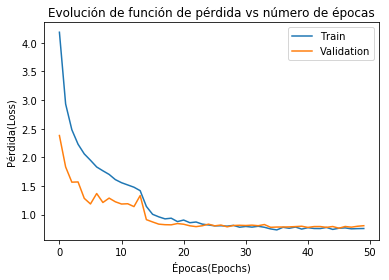

In [163]:
# line
plt.plot(train_losses_act2)
plt.plot(val_losses_act2)

# title
plt.title("Evolución de función de pérdida vs número de épocas")

# labels de los ejes
plt.ylabel('Pérdida(Loss)')
plt.xlabel('Épocas(Epochs)')

# leyenda
plt.legend(['Train', 'Validation'])

#### Evolución de exactitud de clasificación vs número de épocas

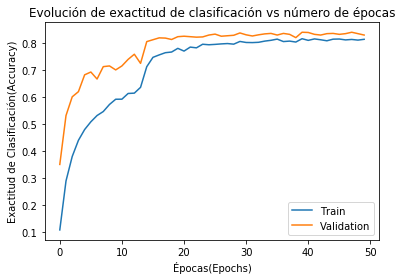

In [164]:
# line
plt.plot(train_acc_act2)
plt.plot(val_acc_act2)

# title
plt.title("Evolución de exactitud de clasificación vs número de épocas")

# labels de los ejes
plt.ylabel('Exactitud de Clasificación(Accuracy)')
plt.xlabel('Épocas(Epochs)')

# leyenda
plt.legend(['Train', 'Validation'])

#### Exactitud de clasificación final en set de test - también obtenemos los mejores y peores resultados por clase (para la Actividad 3)

Source: Ayudantia SidIng

In [136]:
'''
Vamos a testear nuestro modelo entrenado en nuesto set de test, guardando los correctos por clase.
'''

corrects_act2 = {}
examples_per_class_act2 = {}


for i in range(200):
    corrects_act2[i] = 0
    examples_per_class_act2[i] = 0
    

# Iterate over data.
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model_ft_act2(inputs)
    
    _, preds = torch.max(outputs, 1)

    for j in range(4):
        if (labels.data[j].item() == preds[j].item()):
            corrects_act2[preds[j].item()] += 1
            
        examples_per_class_act2[labels[j].item()] += 1
    

In [137]:
# Vamos a Obtener la Exactitud total
print((sum(corrects_act2.values()))
      /(sum(examples_per_class_act2.values())))

0.8336206896551724


Vemos una Exactitud de clasificación Final (Accuracy) en el set de test de 0.8336206896551724 = 83.36206896551724%

#### Analysis Actividad 2

Respecto a la Perdida vemos que la perdida menor en el set de train fue de **0.7319886496662779** y en el set de validación fue de **0.7620384426862082**, las cuales son bastante similares (la del validación un poco mayor, 4% estadisticamente = 0.7620384426862082/0.7319886496662779 - 1), de lo cual se concluye que el modelo se comporta bastante bien, y sin sobre-entrenamiento. También acerca de las pérdidas que va teniendo el modelo a lo largo del tiempo que el set de train baja de manera homogenea en conjunto con el set de validación, vemos que los modelos comvergen en la época 20, es decir, podriamos haberlo entrenado en menos epocas.

Respecto a la exactitud del modelo, vemos que la mayor exactitud en el set de train fue de **0.815897814842183** y en el set de validación fue de **0.8398268398268398**, vemos que la del set de validación fue un tanto mayor, lo que claramente nos relfeja que no estamos teniendo sobre-entrenamiento. Vemos que el modelo connverge en la epoca 20.

Respecto a la Exactitud de clasificación final en el set de test fue de 0.8336206896551724, más cercana a la exactitud del set de validación que el de test, esto quiere decir que nuestra estrategia de validación es correcta.

In [173]:
max(val_acc_act2)

0.8398268398268398

In [138]:
# Vamos a obtener las Accuracies de cada clase para la Actividad 3
acc_per_class_act2 = {}

for class_ in range(200):
    acc_per_class_act2[class_] = ((corrects_act2[class_]) / examples_per_class_act2[class_])

### Actividad 3

Realice una tabla resumen que compare las 2 estrategias de entrenamiento. ¿Cuál es la que obtiene mejores resultados? ¿Cuál(es) clases tiene mejores y peores resultados en términos de exactitud en cada una de las estretegias de entrenamiento? Justifique y entregue ejemplos.

Valor | Actividad 1 | Actividad 2
--- | --- | ---
Best Train Accuracy | 0.1087300749498575 | 0.815897814842183
Best Train Loss | 4.073229166770024 | 0.7319886496662779
Best Val Accuracy | 0.10216450216450217 | 0.8398268398268398
Best Val Loss | 7.33907534776828 | 0.7620384426862082
Test Accuracy | 0.1 | 0.8398268398268398

Observamos claramente que la **Actividad 2 obtiene MEJORES RESULTADOS.** Esto se debe primero que el Test Accuracy es mayor, entonces nuestro modelo es mejor. Tambnién la Actividad 2 no sufre sobre-entrenamiento por lo mencionado en las actividades anteriores. Que la Actividad 2 sea mejor se debe principalmente al Transfer Learning que utilizamos, y debido a la falta de un gran volumen de datos, es la estrategia correcta.


Respecto a las clases que tienen mejores y peores resultados en términos de exactitud en cada una de las estrategias de entrenamiento se observa que: en la Actividad 1 el 68.5% de las clases tienen una exactitud de 0, en cambio en la Actividad 2, sólo el 0.5% de las clases tienen una exactitud de 0. Tambien observamos que ninguna clase de la Actividad 1 tiene una exactitud de 1, en cambio en la Actividad 2, el 47% de las clases tiene una exactitud de 1. Primero, como se menciono anteriormente, estas diferencias son claramente porque el modelo de la Actividad 2 tiene mejores resultados, y en este punto estamos analizando una especie de sub-conjunto. 


### Actividad 4

Repita la **Actividad 1**, pero en lugar de utilizar las funciones de activación del tipo ReLU, utilice funciones sigmoidales de tipo h(x) = 1/(1 + e^(-x)). Compare sus resultados con los obtenidos en la **Actividad 1**

#### Entrenando Modelo

In [143]:
dic_values_act3 = {}

for i in range(50):
    dic_values_act3[i] = []


In [149]:
model_ft_act3 = models.resnet50(pretrained=False)
num_ftrs_act3 = model_ft_act3.fc.in_features
model_ft_act3.fc = nn.Linear(num_ftrs_act3, 200)

# Cambiemos los Relu por Sigmoid (source: https://www.tensorflow.org/api_docs/python/tf/nn)
modules = list(model_ft_act3.modules())

for mod in modules:
    try:
        module.relu = nn.Sigmoid()
    except:
        pass


model_ft_act3 = model_ft_act3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_act3 = optim.SGD(model_ft_act3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_act3, step_size=15, gamma=0.1)

model_ft_act3 = train_model(model_ft_act3, criterion, optimizer_ft_act3, exp_lr_scheduler, dic_values_act3,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 5.5806 Acc: 0.0065
val Loss: 8.5033 Acc: 0.0104

Epoch 1/49
----------
train Loss: 5.2686 Acc: 0.0086
val Loss: 10.9241 Acc: 0.0165

Epoch 2/49
----------
train Loss: 5.1662 Acc: 0.0147
val Loss: 10.4652 Acc: 0.0147

Epoch 3/49
----------
train Loss: 5.1134 Acc: 0.0128
val Loss: 6.2090 Acc: 0.0199

Epoch 4/49
----------
train Loss: 5.0713 Acc: 0.0136
val Loss: 10.1108 Acc: 0.0173

Epoch 5/49
----------
train Loss: 5.0272 Acc: 0.0128
val Loss: 10.6336 Acc: 0.0216

Epoch 6/49
----------
train Loss: 4.9807 Acc: 0.0194
val Loss: 6.4438 Acc: 0.0199

Epoch 7/49
----------
train Loss: 4.9339 Acc: 0.0202
val Loss: 7.2499 Acc: 0.0260

Epoch 8/49
----------
train Loss: 4.8972 Acc: 0.0236
val Loss: 7.5418 Acc: 0.0320

Epoch 9/49
----------
train Loss: 4.8301 Acc: 0.0318
val Loss: 8.3362 Acc: 0.0433

Epoch 10/49
----------
train Loss: 4.7476 Acc: 0.0355
val Loss: 18.3354 Acc: 0.0355

Epoch 11/49
----------
train Loss: 4.6846 Acc: 0.0409
val Loss: 7.7525 Acc: 0.044

In [150]:
train_losses_act4 = []
val_losses_act4 = []

train_acc_act4 = []
val_acc_act4 = []

for epoch in dic_values_act3:
    train_losses_act4.append(dic_values_act3[epoch][0][0])
    val_losses_act4.append(dic_values_act3[epoch][1][0])
    
    train_acc_act4.append(dic_values_act3[epoch][0][1].item())
    val_acc_act4.append(dic_values_act3[epoch][1][1].item())

#### Evolución de función de pérdida vs número de épocas

Text(0.5, 0, 'Épocas(Epochs)')

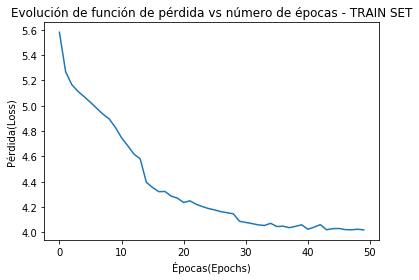

In [151]:
# line
plt.plot(train_losses_act4)

# title
plt.title("Evolución de función de pérdida vs número de épocas - TRAIN SET")

# labels de los ejes
plt.ylabel('Pérdida(Loss)')
plt.xlabel('Épocas(Epochs)')

Text(0.5, 0, 'Épocas(Epochs)')

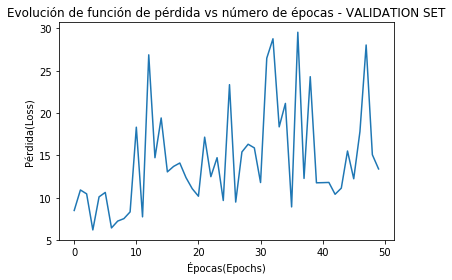

In [152]:
# line
plt.plot(val_losses_act4)

# title
plt.title("Evolución de función de pérdida vs número de épocas - VALIDATION SET")

# labels de los ejes
plt.ylabel('Pérdida(Loss)')
plt.xlabel('Épocas(Epochs)')

#### Evolución de exactitud de clasificación vs número de épocas

Text(0.5, 0, 'Épocas(Epochs)')

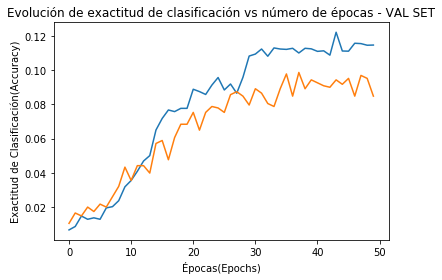

In [157]:
# line
plt.plot(train_acc_act4)
plt.plot(val_acc_act4)

# title
plt.title("Evolución de exactitud de clasificación vs número de épocas - VAL SET")

# labels de los ejes
plt.ylabel('Exactitud de Clasificación(Accuracy)')
plt.xlabel('Épocas(Epochs)')

In [ ]:
# line
plt.plot(val_acc_act4)

# title
plt.title("Evolución de exactitud de clasificación vs número de épocas - VAL SET")

# labels de los ejes
plt.ylabel('Exactitud de Clasificación(Accuracy)')
plt.xlabel('Épocas(Epochs)')

#### Exactitud de clasificación final en set de test

Source: Ayudantia SidIng

In [155]:
'''
Vamos a testear nuestro modelo entrenado en nuesto set de test, guardando los correctos por clase.
'''

corrects_act4 = {}
examples_per_class_act4 = {}


for i in range(200):
    corrects_act4[i] = 0
    examples_per_class_act4[i] = 0
    

# Iterate over data.
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model_ft(inputs)
    
    _, preds = torch.max(outputs, 1)

    for j in range(4):
        if (labels.data[j].item() == preds[j].item()):
            corrects_act4[preds[j].item()] += 1
            
        examples_per_class_act4[labels[j].item()] += 1
    

In [156]:
# Vamos a Obtener la Exactitud total
print((sum(corrects_act4.values()))
      /(sum(examples_per_class_act4.values())))

0.1


Vemos una Exactitud de clasificación Final (Accuracy) en el set de test de 0.1 = 10%

#### Analysis Actividad 4

Primero, es importante destacar que el único cambio que se realizó fue las ReLU por Sigmoid.

Respecto a la Perdida vemos que la perdida menor en el set de train fue de **4.019984813749784** y en el set de val fue de **6.208960219379112**, sin duda esto es un reflejo que nuestro modelo se esta **sobre-entrenando**. También acerca de las pérdidas que va teniendo el modelo a lo largo del tiempo que el set de train baja de manera homogenea, y el modelo el train de set totalmente heterogenea, teniendo unos peaks muy extraños. Esto se debe a que la actualización de los pesos no esta siendo efectiva, ya sea por el **sobre-entrenamiento** que esta generando el modelo, o también porque el batch_size que utilice es muy pequeño.

Respecto a la exactitud del modelo, vemos que la mayor exactitud en el set de train fue de **0.12224216193391745** y en el set de val fue de **0.0987012987012987**, siendo la del train de set mayor en **0.02354086323**, lo cual corresponde a un 23.8% mayor (estadisticamente = 0.12224216193391745/0.0987012987012987 - 1), lo cual si se considera representativo. Que la exactitud sea mayor en el set de train es un relfejo que existe un **sobre-entrenamiento**. También observando los gráficos se  en un comienzo suben homogenamente, pero desde un punto se separan (muy sutilmente, siendo que el Train continua subiendo y el Validate converge. Estas "separaciones" se deben a un **sobre-entrenando**. Esta separación ocurre en la epoca 15.

Respecto a la Exactitud de clasificación final en el set de test fue de 0.1, más cercana a la exactitud del set de validación que el de test, esto quiere decir que nuestra estrategia de validación es correcta. Problemas de este sobre-entrenamiento que ha sido mencionado a lo largo del analysis se puede deber que no tenemos muchos datos, lo cual es uno de los puntos fundamentales para obtener buenos resultados en redes de aprendizaje de máquinas profundas, o puede haber existido una mala definición de lo Hyperparametros, sin embargo, mi intuición e investogación tanto lo que hemos visto en clases como lo que he investigado por mi cuenta se debe a la primer argumento.


Realizando la comparación con los resultado obtenidos en la Actividad 1, se observa que **la Actividad 4 tiene PEORES RESULTADOS y CONVERGE MAS LENTO.** (1) El sobre-entrenamiento en la Actividad 4 es mucho más grande, debido a que alcanza una diferencia estadistica del 23.8% entre el set de Test y Validación, en cambio la Actividad 1 sólo un 6.5%. También observamos que converge más lento, dado que la Actividad 4 converge en la epoca 15, y la Actividad 1 en la pecoa 13.

In [201]:
max(val_acc_act4)

0.0987012987012987

Para hacerlo de maner ordenada, no voy a hacer un cuadro comparativo como tal, sino voy a hablar de cada una de las funciones de perdida por separado.



**Triplet Loss**
Es un algoritmo de aprendizaje que para redes neuronales de inteligencia artificial donde un input (a evaluar) (anchor) es comparado con un input con label positivo y otro con label negativo. Entonces, se **maximixa** la distancia entre en input (a evaluar) con el input con label negativo y se **minimiza** con el input con label positivo.

Como observamos en el Articulo Lossless Triplet loss (source: https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24), lo que se busca es acercar tu input lo mas posible al caso de dar una predicción positiva, y alejarla a que de una predicción negativa.

Uno de los parametros que tiene es un margin parameter, el cual es denominado con un alpha, el cual indica que tanto menor tiene que ser el positivo. Bueno también como parametro de la función estan las distancias mencionadas anteriormente.

Una de las tareas que se utilizan es para la Face Recognition, donde debemos comparar tu imagen de entrada (anchor) tanto con imagenes positivas (misma persona) como otras negativas (personas distintas). 


**Focal Loss**
Partiendo explicando el Cross Entropy Loss, que se usa para la clasificación, el problema es que para Cross Entropy, no funciona bien en el caso de tener muchos ejemplos sencillos, pueden abrumar las clases mas complejas. Entonces para solucionar este el Focal Loss agrega un parametro, que le baja la incidencia de los pesos a los ejmplos faciles, y concentrando el entrenamiento en los más dificiles.

Los parametros que tiene Focal loss es el y, llamada focusing parameter, que su función es ajustar que ejemplos tienen pesos bajos. Entonces cuando y = 0, Focal Loss es igual a Cross Entropy, y cuando y va aumentando, el efecto va aumentando.

Entonces se usa en problemas de clasificación donde tenemos muchas imagenes sencillas, y sólo algunas dificiles. Por ejemplo, un amnbiente peatonal